# Fake News Detection using ML Techniques - 2 vectorizers with Random Forest and Logistic Regression

# RF Best - 35.9% on test set - 6 way
# RF Best - 72% on test set - Binary

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Importing the required libraries and setting up the spacy pipeline for lemmatization only support

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#from textblob import TextBlob,Word
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import string
print(string.punctuation)
import spacy
nlp = spacy.load('en', disable=['ner', 'parser'])



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/ML_Practice/exp3/'

## Preparing the data

Following steps are perforemd while preparing the data


1.   Downloading the data and loading the data in pandas dataframe
2.   Identification of missing values and replacing numerical values with median and the text values with NA
3.   Adding the combined column by using the context, statement and justification column.
4.   Splitting and Encoding the subject column as one-hot vectors
5.   Pre-processing the combined columns to remove punctuations, unwanted space and newline characters.
6.  Preparing the binary class label
7.  Fitting the tfidf vector on the positive and negative train set classes on the combined column.
8.  Transforming the train, valid and test data combined column from the tfidf vectorizer fitted on the train set.
9.  Combining the tfidf vectorizer features and the relevant columns of original dataframe and saving the train,test and valid set in feather format
10. Hyper-Parameter tuning on Logistic Regression



### Import  Data

In [7]:
!wget https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/train2.tsv

--2019-08-09 10:32:34--  https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/train2.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6969628 (6.6M) [text/plain]
Saving to: ‘train2.tsv’

train2.tsv          100%[===================>]   6.65M  --.-KB/s    in 0.07s   

2019-08-09 10:32:34 (95.0 MB/s) - ‘train2.tsv’ saved [6969628/6969628]



In [8]:
!wget https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/val2.tsv

--2019-08-09 10:32:47--  https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/val2.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 863858 (844K) [text/plain]
Saving to: ‘val2.tsv’

val2.tsv            100%[===================>] 843.61K  --.-KB/s    in 0.04s   

2019-08-09 10:32:47 (19.3 MB/s) - ‘val2.tsv’ saved [863858/863858]



In [9]:
!wget https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/test2.tsv

--2019-08-09 10:32:51--  https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/test2.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 869788 (849K) [text/plain]
Saving to: ‘test2.tsv’

test2.tsv           100%[===================>] 849.40K  --.-KB/s    in 0.04s   

2019-08-09 10:32:51 (22.6 MB/s) - ‘test2.tsv’ saved [869788/869788]



In [0]:
!wget https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/forbidden_words.txt

In [0]:
with open("forbidden_words.txt") as f: # Print forbidden words
  print(f.read())

In [0]:
df_train = pd.read_csv("train2.tsv", sep="\t", header=None)

In [0]:
df_valid = pd.read_csv("val2.tsv", sep="\t", header=None)

In [0]:
df_test = pd.read_csv("test2.tsv", sep="\t", header=None)

In [0]:
df_train[3].values[:1]

In [0]:
df_train.head()

### Fill Missing Values

In [0]:
df_cols = ['label', 'statement', 'subject', 'speaker', 'speaker_job', 'state', 'party_affiliation', 
           'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context', 'justification']
# col 8 - 12 are historical counts for person

In [0]:
df_train = df_train.drop(columns=[0, 1]) ; df_train.columns = df_cols

In [0]:
df_valid = df_valid.drop(columns=[0, 1]) ; df_valid.columns = df_cols

In [0]:
df_test = df_test.drop(columns=[0, 1]) ; df_test.columns = df_cols

In [0]:
df_train['subject'].fillna("NA", inplace = True)
df_valid['subject'].fillna("NA", inplace = True)
df_test['subject'].fillna("NA", inplace = True)

df_train['speaker'].fillna("NA", inplace = True)
df_valid['speaker'].fillna("NA", inplace = True)
df_test['speaker'].fillna("NA", inplace = True)

df_train['speaker_job'].fillna("NA", inplace = True)
df_valid['speaker_job'].fillna("NA", inplace = True)
df_test['speaker_job'].fillna("NA", inplace = True)

df_train['party_affiliation'].fillna("NA", inplace = True)
df_valid['party_affiliation'].fillna("NA", inplace = True)
df_test['party_affiliation'].fillna("NA", inplace = True)

df_train['context'].fillna("NA", inplace = True)
df_valid['context'].fillna("NA", inplace = True)
df_test['context'].fillna("NA", inplace = True)

df_train['state'].fillna("NA", inplace = True)
df_valid['state'].fillna("NA", inplace = True)
df_test['state'].fillna("NA", inplace = True)


df_train['justification'].fillna("NA", inplace = True)
df_valid['justification'].fillna("NA", inplace = True)
df_test['justification'].fillna("NA", inplace = True)

df_train['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)
df_valid['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)
df_test['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)


df_train['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)
df_valid['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)
df_test['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)


df_train['false'].fillna(df_train['false'].median(), inplace = True)
df_valid['false'].fillna(df_train['false'].median(), inplace = True)
df_test['false'].fillna(df_train['false'].median(), inplace = True)

df_train['half_true'].fillna(df_train['half_true'].median(), inplace = True)
df_valid['half_true'].fillna(df_train['half_true'].median(), inplace = True)
df_test['half_true'].fillna(df_train['half_true'].median(), inplace = True)

df_train['mostly_true'].fillna(df_train['mostly_true'].median(), inplace = True)
df_valid['mostly_true'].fillna(df_train['mostly_true'].median(), inplace = True)
df_test['mostly_true'].fillna(df_train['mostly_true'].median(), inplace = True)

df_train['pants_on_fire'].fillna(df_train['pants_on_fire'].median(), inplace = True)
df_valid['pants_on_fire'].fillna(df_train['pants_on_fire'].median(), inplace = True)
df_test['pants_on_fire'].fillna(df_train['pants_on_fire'].median(), inplace = True)





In [0]:
df_train[:3]

In [0]:
len(df_train) - df_train.count()

In [0]:
len(df_valid) - df_valid.count()

In [0]:
len(df_test) - df_test.count()

# Creating the combined column

In [0]:
df_train['combined'] = df_train['context'] + ' '+ df_train['statement'] + ' ' + df_train['justification']
df_valid['combined'] = df_valid['context'] + ' '+ df_valid['statement'] + ' ' + df_valid['justification']
df_test['combined'] = df_test['context'] + ' '+ df_test['statement'] + ' ' + df_test['justification']

# Splitting the subject column and one-hot encoding

In [0]:
l = list(df_train.subject.str.split(','))

In [20]:
s = set()
for i in l:
    for j in i:
        if j not in s:
            s.add(j)
len(list(s))

143

In [0]:
for sub in (list(s)):
    df_train[f'sub_{sub}'] = [1 if sub in x.split(',') else 0 for x in df_train['subject']]
    df_valid[f'sub_{sub}'] = [1 if sub in x.split(',') else 0 for x in df_valid['subject']]
    df_test[f'sub_{sub}'] = [1 if sub in x.split(',') else 0 for x in df_test['subject']]

In [0]:
df_test[:1]

# Preparing the binary label

In [0]:
df_train['label_binaray'] = [True if x in ['true','mostly-true','half-true'] else False for x in df_train['label']] 
df_valid['label_binaray'] = [True if x in ['true','mostly-true','half-true'] else False for x in df_valid['label']] 
df_test['label_binaray'] = [True if x in ['true','mostly-true','half-true'] else False for x in df_test['label']] 

In [44]:
df_train.groupby(['label_binaray'])['label'].count()

label_binaray
False    4488
True     5752
Name: label, dtype: int64

#### Preprocessing and fitting the tfidf vectorizer

In [0]:
def preprocess_text(df,colname):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df[colname] = df[colname].fillna(' ')
    df[colname] = df[colname].str.replace('\n',' ')
    df[colname] = df[colname].str.replace('\r',' ')
    return df

In [0]:
# preprocess the text to deal with known issues
df_train = preprocess_text(df_train,'combined')
df_valid = preprocess_text(df_valid,'combined')
df_test = preprocess_text(df_test,'combined')

In [0]:
def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words    
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)   # removing punctuations
    doc = nlp(text) 
    text = ' '.join([str(token.lemma_) for token in doc]) # lemmatization using spaCy
    tokens = word_tokenize(text) # tokenization using nltk
    return tokens

In [39]:
tokenizer_better('This should be tokenized. 02/02/2018 sentence has stars**')

['this', 'should', 'be', 'tokenize', 'sentence', 'have', 'star']

In [0]:
tfidfVectorizer = f'{root_path}tfidfVectorizer_'
tfidfVectorizer_pos = f'{root_path}tfidfVectorizer_pos_'
tfidfVectorizer_neg = f'{root_path}tfidfVectorizer_neg_'

import joblib
# joblib.dump(vect, f'{tfidfVectorizer}3000.pkl')

# Creating parallel threads for faster learning

In [0]:
from multiprocessing import Process
from scipy import sparse

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [0]:
pos = df_train['label_binaray']==True
neg = df_train['label_binaray']==False

In [0]:
df_train_pos = df_train[pos].copy()
df_train_neg = df_train[neg].copy()

In [0]:
def vect_pos_train():
    vect_pos = None
    if (os.path.exists(f'{tfidfVectorizer_pos}3000.pkl')):
      vect_pos = joblib.load(f'{tfidfVectorizer_pos}3000.pkl')
      print('Here1')
    else:
      vect_pos = TfidfVectorizer(lowercase = True, max_features = 5000,ngram_range=(1, 3), 
                               tokenizer = tokenizer_better,stop_words = None)
      print('Fitting vectorizer')
      vect_pos.fit(df_train_pos['combined'].values)
      joblib.dump(vect_pos, f'{tfidfVectorizer_pos}3000.pkl')
      print('Here')


In [0]:
def vect_neg_train():
    vect_neg = None
    if (os.path.exists(f'{tfidfVectorizer_neg}3000.pkl')):
      vect_neg = joblib.load(f'{tfidfVectorizer_neg}3000.pkl')
      print('Here1')
    else:
      vect_neg = TfidfVectorizer(lowercase = True, max_features = 3000,ngram_range=(1, 3), 
                               tokenizer = tokenizer_better,stop_words = None)
      print('Fitting vectorizer')
      vect_neg.fit(df_train_neg['combined'].values)
      joblib.dump(vect_neg, f'{tfidfVectorizer_neg}3000.pkl')
      print('Here')

In [52]:
p1 = Process(target=vect_pos_train)
p1.start()
p2 = Process(target=vect_neg_train)
p2.start()
print('Here')
p1.join()
p2.join()
print('Here')

Here
Fitting vectorizer
Fitting vectorizer
Here
Here
Here


In [0]:
vect_neg = joblib.load(f'{tfidfVectorizer_neg}3000.pkl')
vect_pos = joblib.load(f'{tfidfVectorizer_pos}3000.pkl')

In [0]:
def train_pos():
    from scipy import sparse
    X_train_tf_pos = vect_pos.transform(df_train['combined'].values)
    sparse.save_npz(f'{tfidfVectorizer_pos}3000_train.npz', X_train_tf_pos)
    y_train_binary = df_train['label_binaray']
    y_train =  df_train['label']
    np.save('y_train.npy', y_train)
    np.save('y_train_binary.npy', y_train_binary)


In [0]:
def train_neg():
    from scipy import sparse
    X_train_tf_neg = vect_neg.transform(df_train['combined'].values)
    sparse.save_npz(f'{tfidfVectorizer_neg}3000_train.npz', X_train_tf_neg)
    

In [0]:
def valid_pos():
    from scipy import sparse
    X_valid_tf_pos = vect_pos.transform(df_valid['combined'].values)
    sparse.save_npz(f'{tfidfVectorizer_pos}3000_valid.npz', X_valid_tf_pos)
    y_valid_binary = df_valid['label_binaray']
    y_valid =  df_valid['label']
    np.save('y_valid.npy', y_valid)
    np.save('y_valid_binary.npy', y_valid_binary)


In [0]:
def valid_neg():
    from scipy import sparse
    X_valid_tf_neg = vect_neg.transform(df_valid['combined'].values)
    sparse.save_npz(f'{tfidfVectorizer_neg}3000_valid.npz', X_valid_tf_neg)
    

In [0]:
def test_pos():
    from scipy import sparse
    X_test_tf_pos = vect_pos.transform(df_test['combined'].values)
    sparse.save_npz(f'{tfidfVectorizer_pos}3000_test.npz', X_test_tf_pos)
    y_test_binary = df_test['label_binaray']
    y_test =  df_test['label']
    np.save('y_test.npy', y_test)
    np.save('y_test_binary.npy', y_test_binary)


In [0]:
def test_neg():
    from scipy import sparse
    X_test_tf_neg = vect_neg.transform(df_test['combined'].values)
    sparse.save_npz(f'{tfidfVectorizer_neg}3000_test.npz', X_test_tf_neg)
 

In [60]:
p1 = Process(target=train_pos)
p1.start()
p2 = Process(target=train_neg)
p2.start()
p3 = Process(target=valid_pos)
p3.start()

p4 = Process(target=valid_neg)
p4.start()
p5 = Process(target=test_pos)
p5.start()
p6 = Process(target=test_neg)
p6.start()
print("here")
p1.join()
p2.join()
p3.join()
print("here")

p4.join()
p5.join()
p6.join()
print("here")

here
here
here


In [0]:
X_train_tf_pos = None
X_train_tf_neg = None

X_valid_tf_pos = None
X_valid_tf_neg = None

X_test_tf_pos = None
X_test_tf_neg = None

y_train = None
y_valid = None
y_train_binary = None
y_valid_binary = None
y_test = None
y_test_binary = None


from scipy import sparse

if(os.path.exists(f'{tfidfVectorizer_pos}3000_train.npz')):   
    X_train_tf_pos = sparse.load_npz(f'{tfidfVectorizer_pos}3000_train.npz')
    X_train_tf_neg = sparse.load_npz(f'{tfidfVectorizer_neg}3000_train.npz')
    y_train = np.load(f'{root_path}y_train.npy',allow_pickle=True)
    y_train_binary = np.load(f'{root_path}y_train_binary.npy',allow_pickle=True)
    
        
    
if (os.path.exists(f'{tfidfVectorizer_pos}3000_valid.npz')):  
    X_valid_tf_pos = sparse.load_npz(f'{tfidfVectorizer_pos}3000_valid.npz')
    X_valid_tf_neg = sparse.load_npz(f'{tfidfVectorizer_neg}3000_valid.npz')
    
    y_valid = np.load(f'{root_path}y_valid.npy',allow_pickle=True)    
    y_valid_binary = np.load(f'{root_path}y_valid_binary.npy',allow_pickle=True)
    
if (os.path.exists(f'{tfidfVectorizer_pos}3000_test.npz')):  
    X_test_tf_pos = sparse.load_npz(f'{tfidfVectorizer_pos}3000_test.npz')
    X_test_tf_neg = sparse.load_npz(f'{tfidfVectorizer_neg}3000_test.npz')
    
    y_test = np.load(f'{root_path}y_test.npy',allow_pickle=True)    
    y_test_binary = np.load(f'{root_path}y_test_binary.npy',allow_pickle=True)
    
    


In [0]:


y_train = np.load(f'{root_path}y_train.npy',allow_pickle=True)
y_train_binary = np.load(f'{root_path}y_train_binary.npy',allow_pickle=True)

y_valid = np.load(f'{root_path}y_valid.npy',allow_pickle=True)    
y_valid_binary = np.load(f'{root_path}y_valid_binary.npy',allow_pickle=True)


y_test = np.load(f'{root_path}y_test.npy',allow_pickle=True)    
y_test_binary = np.load(f'{root_path}y_test_binary.npy',allow_pickle=True)
    
    

# Combining the relevant columns

In [0]:
df_train_temp_pos = pd.DataFrame(X_train_tf_pos.toarray(),columns=vect_pos.get_feature_names())
df_train_temp_neg = pd.DataFrame(X_train_tf_neg.toarray(),columns=vect_neg.get_feature_names())

df_valid_temp_pos = pd.DataFrame(X_valid_tf_pos.toarray(),columns=vect_pos.get_feature_names())
df_valid_temp_neg = pd.DataFrame(X_valid_tf_neg.toarray(),columns=vect_neg.get_feature_names())

df_test_temp_pos = pd.DataFrame(X_test_tf_pos.toarray(),columns=vect_pos.get_feature_names())
df_test_temp_neg = pd.DataFrame(X_test_tf_neg.toarray(),columns=vect_neg.get_feature_names())

In [0]:
final_cols = []
for i in df_train.columns:
    if i not in ['label','statement','subject','context','justification','combined','label_binaray']:
        final_cols.append(i)

In [132]:
final_cols

['speaker',
 'speaker_job',
 'state',
 'party_affiliation',
 'barely_true',
 'false',
 'half_true',
 'mostly_true',
 'pants_on_fire',
 'sub_redistricting',
 'sub_campaign-advertising',
 'sub_job-accomplishments',
 'sub_veterans',
 'sub_new-hampshire-2012',
 'sub_welfare',
 'sub_religion',
 'sub_sports',
 'sub_debt',
 'sub_diversity',
 'sub_bipartisanship',
 'sub_social-security',
 'sub_drugs',
 'sub_income',
 'sub_supreme-court',
 'sub_candidates-biography',
 'sub_military',
 'sub_jobs',
 'sub_congressional-rules',
 'sub_message-machine-2014',
 'sub_foreign-policy',
 'sub_sotomayor-nomination',
 'sub_retirement',
 'sub_tourism',
 'sub_states',
 'sub_nuclear',
 'sub_gambling',
 'sub_taxes',
 'sub_families',
 'sub_message-machine',
 'sub_debates',
 'sub_cap-and-trade',
 'sub_abc-news-week',
 'sub_pensions',
 'sub_water',
 'sub_occupy-wall-street',
 'sub_federal-budget',
 'sub_terrorism',
 'sub_after-the-fact',
 'sub_marriage',
 'sub_disability',
 'sub_animals',
 'sub_public-service',
 's

In [0]:
df_train_temp = df_train[final_cols].copy()
df_valid_temp = df_valid[final_cols].copy()
df_test_temp = df_test[final_cols].copy()

In [0]:
df_train_final = pd.concat([df_train_temp_pos, df_train_temp_neg,df_train_temp], ignore_index=False, sort=False,axis=1)
df_valid_final = pd.concat([df_valid_temp_pos, df_valid_temp_neg,df_valid_temp], ignore_index=False, sort=False,axis=1)
df_test_final = pd.concat([df_test_temp_pos, df_test_temp_neg,df_test_temp], ignore_index=False, sort=False,axis=1)

In [0]:
df_train_final.drop(columns=['speaker','state'],inplace=True)
df_valid_final.drop(columns=['speaker','state'],inplace=True)
df_test_final.drop(columns=['speaker','state'],inplace=True)


# Conversion to categorical variables and downtyping the columns for spatial efficiency

In [0]:
df_train_final['speaker'] = df_train['speaker'].astype('category')
df_valid_final['speaker'] = df_valid['speaker']
df_test_final['speaker'] = df_test['speaker']

df_train_final['state'] = df_train['state'].astype('category')
df_valid_final['state'] = df_valid['state']
df_test_final['state'] = df_test['state']


In [151]:
df_train_final[final_cols].head()

,speaker,speaker_job,state,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,sub_redistricting,sub_campaign-advertising,sub_job-accomplishments,sub_veterans,sub_new-hampshire-2012,sub_welfare,sub_religion,sub_sports,sub_debt,sub_diversity,sub_bipartisanship,sub_social-security,sub_drugs,sub_income,sub_supreme-court,sub_candidates-biography,sub_military,sub_jobs,sub_congressional-rules,sub_message-machine-2014,sub_foreign-policy,sub_sotomayor-nomination,sub_retirement,sub_tourism,sub_states,sub_nuclear,sub_gambling,sub_taxes,sub_families,sub_message-machine,sub_debates,...,sub_weather,sub_florida,sub_israel,sub_small-business,sub_colbert-report,sub_deficit,sub_bush-administration,sub_guns,sub_transparency,sub_consumer-safety,sub_population,sub_oil-spill,sub_Alcohol,sub_unions,sub_message-machine-2012,sub_transportation,sub_county-government,sub_space,sub_science,sub_sexuality,sub_state-finances,sub_fake-news,sub_corrections-and-updates,sub_kagan-nomination,sub_stimulus,sub_agriculture,sub_energy,sub_homeland-security,sub_state-budget,sub_recreation,sub_government-efficiency,sub_food,sub_ethics,sub_infrastructure,sub_food-safety,sub_trade,sub_history,sub_women,sub_abortion,sub_hunger
0,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False
2,barack-obama,President,Illinois,democrat,70,71,160,163,9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,blog-posting,NA,NA,none,7,19,3,5,44,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,charlie-crist,NA,Florida,democrat,15,9,20,19,2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [138]:
zz = ['party_affiliation',  'speaker_job']
for col in zz:
    print(col)
    df_train_final[col] = df_train_final[col].astype('category')
    #df_train_final[col] = df_train_final[col].apply(lambda x: x.cat.codes)
    
#     df_valid_final[col] = df_valid_final[col].astype('category')
#     #df_train_final[col] = df_train_final[col].apply(lambda x: x.cat.codes)
    
#     df_test_final[col] = df_test_final[col].astype('category')
#     #df_test_final[col] = df_test_final[col].apply(lambda x: x.cat.codes)

party_affiliation
speaker_job


In [0]:
# cat_columns = df_train_final.select_dtypes(['category']).columns
# cat_columns

# df_train_final[cat_columns] = df_train_final[cat_columns].apply(lambda x: x.cat.codes)

# df_valid_final[cat_columns] = df_valid_final[cat_columns].apply(lambda x: x.cat.codes)

# df_test_final[cat_columns] = df_test_final[cat_columns].apply(lambda x: x.cat.codes)

In [0]:
# From FastAI
def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
        """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtypes.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)


In [0]:
apply_cats(df_valid_final,df_train_final)

In [0]:
apply_cats(df_test_final,df_train_final)

In [0]:
final_cols[4:9]
for col in final_cols[4:9]:
  df_train_final[col] = df_train[col].astype(np.int16)

  df_valid_final[col] = df_valid[col].astype(np.int16)

  df_test_final[col] = df_test[col].astype(np.int16)
  

In [0]:
for col in final_cols[9:]:
  df_train_final[col] = df_train_final[col].astype(np.bool)

  df_valid_final[col] = df_valid_final[col].astype(np.bool)

  df_test_final[col] = df_test_final[col].astype(np.bool)
  

In [161]:
df_train_final.shape

(10240, 8148)

In [1]:
df_valid_final.shape

NameError: ignored

In [163]:
df_test_final.shape

(1267, 8148)

# Removing duplicate columns created by the tfidf_pos and tfidf_neg vector and saving files to feather format for ease for quick reading from the disk

In [0]:
trial = df_train_final.loc[:,~df_train_final.columns.duplicated()]

In [179]:
trial.shape

(10240, 5198)

In [0]:
trial.to_feather(f'{root_path}train')

In [0]:
trial = df_valid_final.loc[:,~df_valid_final.columns.duplicated()]

In [182]:
trial.shape

(1284, 5198)

In [0]:
trial.to_feather(f'{root_path}valid')

In [0]:
trial = df_test_final.loc[:,~df_test_final.columns.duplicated()]

In [185]:
trial.shape

(1267, 5198)

In [0]:
trial.to_feather(f'{root_path}test')

# Hyperparameter tuning and reporting results

In [0]:
df_train = pd.read_feather(f'{root_path}train')
df_valid = pd.read_feather(f'{root_path}valid')
df_test = pd.read_feather(f'{root_path}test')

In [0]:
def calc_accuracy(y_actual, y_pred, thresh=0.5):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1.0))+sum((y_pred < thresh) & (y_actual == 0.0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh=0.5):
    # calculates the recall
    if sum(y_actual)==0.0:
        return 0.0
    return sum((y_pred > thresh) & (y_actual == 1.0)) /(sum(y_actual))

def calc_precision(y_actual, y_pred, thresh=0.5):
    # calculates the precision
    if sum(y_pred > thresh)==0:
        return 0.0
    return sum((y_pred > thresh) & (y_actual == 1.0)) /(sum(y_pred > thresh))

def calc_specificity(y_actual, y_pred, thresh=0.5):
    # calculates specificity
    if sum(y_actual ==0)==0.0:
        return 0.0
    return sum((y_pred < thresh) & (y_actual == 0.0)) /(sum(y_actual ==0.0))

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1.0)) /len(y_actual)
  
def calc_f1(y_actual, y_pred, thresh=0.5):
    # calculates the recall
    precision = calc_precision(y_actual, y_pred, thresh)
    #print('precsion',precision)
    recall = calc_recall(y_actual, y_pred, thresh)
    #print('recall',recall)
    if precision + recall ==0.0:
      return 0.0
    f1 = float(2*precision*recall)/float(precision+recall)
    return f1


In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def print_metrics(y_actual_first, y_pred_first, name_first='valid',thresh=0.5):#, y_actual_second, y_pred_second, name_second):
  fpr_first, tpr_first, thresholds_first = roc_curve(y_actual_first, y_pred_first)
  #fpr_second, tpr_second, thresholds_second = roc_curve(y_actual_second, y_pred_second)


  
  auc_first = roc_auc_score(y_actual_first, y_pred_first)
  #auc_second = roc_auc_score(y_actual_second, y_pred_second)
  
  print(name_first, 'AUC:%.3f'%auc_first)
  #print(name_second, 'AUC:%.3f'%auc_second)

  print(name_first, 'accuracy:%.3f'%calc_accuracy(y_actual_first, y_pred_first, thresh))
  #print(name_second, 'accuracy:%.3f'%calc_accuracy(y_actual_second, y_pred_second, thresh))

  print(name_first, 'recall:%.3f'%calc_recall(y_actual_first, y_pred_first, thresh))
  #print(name_second, 'recall:%.3f'%calc_recall(y_actual_second, y_pred_second, thresh))
  
  print(name_first, 'precision:%.3f'%calc_precision(y_actual_first, y_pred_first, thresh))
  #print(name_second, 'precision:%.3f'%calc_precision(y_actual_second, y_pred_second, thresh))
  
  print(name_first, 'F1:%.3f'%calc_f1(y_actual_first, y_pred_first, thresh))
  #print(name_second, 'precision:%.3f'%calc_precision(y_actual_second, y_pred_second, thresh))
  
  print(name_first, 'specificity:%.3f'%calc_specificity(y_actual_first, y_pred_first, thresh))
  #print(name_second, 'specificity:%.3f'%calc_specificity(y_actual_second, y_pred_second, thresh))
  
  print(name_first, 'prevalence:%.3f'%calc_prevalence(y_actual_first))
  #print(name_second, 'prevalence:%.3f'%calc_prevalence(y_actual_second))
  
  
  plt.plot(fpr_first, tpr_first,'r-', label = name_first + ' AUC: %.2f'%auc_first)
  #plt.plot(fpr_second, tpr_second,'b-',label = name_second + ' AUC: %.2f'%auc_second)
  plt.plot([0,1],[0,1],'-k')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble.forest import RandomForestClassifier


In [15]:
df_train.shape

(10240, 5198)

In [0]:
n_jobs=-1

In [0]:
cat_columns = df_train.select_dtypes(['category']).columns
df_train[cat_columns] = df_train[cat_columns].apply(lambda x: x.cat.codes)

df_valid[cat_columns] = df_valid[cat_columns].apply(lambda x: x.cat.codes)

df_test[cat_columns] = df_test[cat_columns].apply(lambda x: x.cat.codes)

# LR fine-tuning and evaluation


 C: 0.001
valid AUC:0.642
valid accuracy:0.604
valid recall:0.918
valid precision:0.595
valid F1:0.722
valid specificity:0.200
valid prevalence:0.562


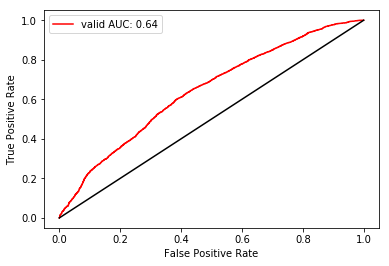


 C: 0.002
valid AUC:0.637
valid accuracy:0.614
valid recall:0.919
valid precision:0.603
valid F1:0.728
valid specificity:0.224
valid prevalence:0.562


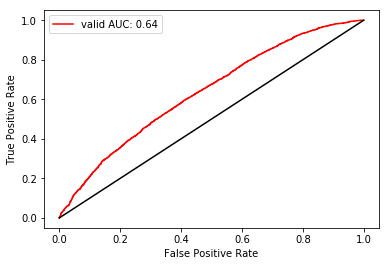


 C: 0.003
valid AUC:0.640
valid accuracy:0.611
valid recall:0.897
valid precision:0.603
valid F1:0.721
valid specificity:0.245
valid prevalence:0.562


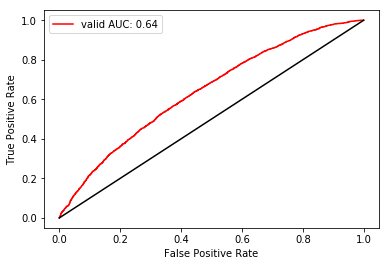


 C: 0.005
valid AUC:0.645
valid accuracy:0.617
valid recall:0.895
valid precision:0.608
valid F1:0.724
valid specificity:0.261
valid prevalence:0.562


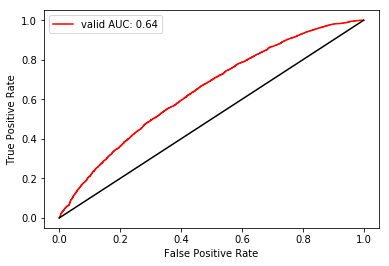


 C: 0.01
valid AUC:0.646
valid accuracy:0.619
valid recall:0.879
valid precision:0.612
valid F1:0.721
valid specificity:0.285
valid prevalence:0.562


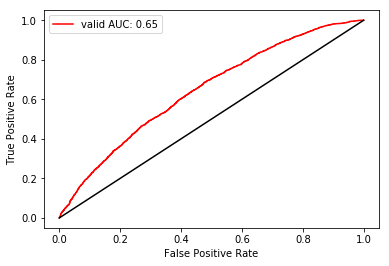


 C: 0.02
valid AUC:0.646
valid accuracy:0.617
valid recall:0.874
valid precision:0.611
valid F1:0.720
valid specificity:0.288
valid prevalence:0.562


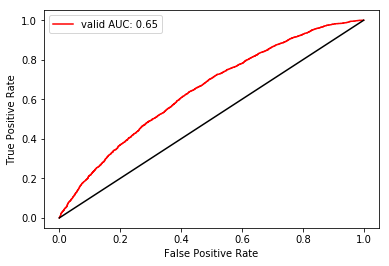


 C: 0.03
valid AUC:0.646
valid accuracy:0.619
valid recall:0.855
valid precision:0.616
valid F1:0.716
valid specificity:0.317
valid prevalence:0.562


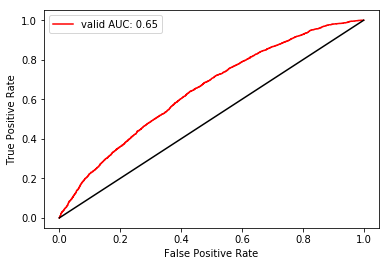


 C: 0.05
valid AUC:0.647
valid accuracy:0.615
valid recall:0.864
valid precision:0.611
valid F1:0.716
valid specificity:0.296
valid prevalence:0.562


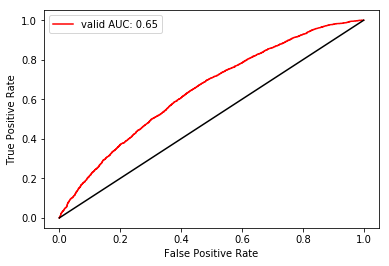


 C: 0.1
valid AUC:0.646
valid accuracy:0.616
valid recall:0.860
valid precision:0.613
valid F1:0.716
valid specificity:0.303
valid prevalence:0.562


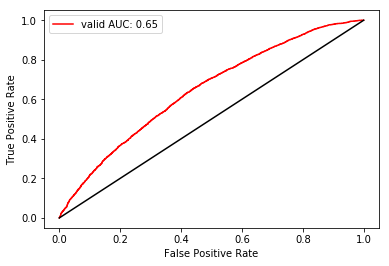


 C: 0.2
valid AUC:0.648
valid accuracy:0.617
valid recall:0.857
valid precision:0.614
valid F1:0.715
valid specificity:0.310
valid prevalence:0.562


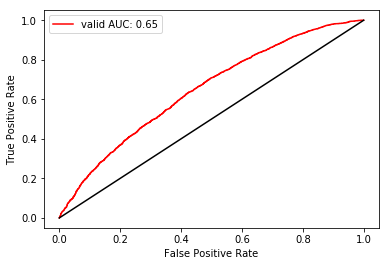


 C: 0.5
valid AUC:0.646
valid accuracy:0.616
valid recall:0.857
valid precision:0.613
valid F1:0.715
valid specificity:0.308
valid prevalence:0.562


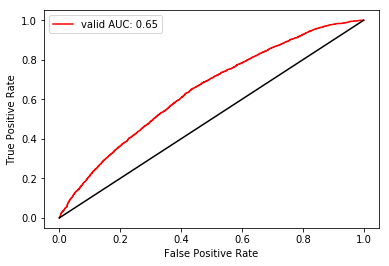


 C: 1.0
valid AUC:0.647
valid accuracy:0.613
valid recall:0.860
valid precision:0.611
valid F1:0.714
valid specificity:0.297
valid prevalence:0.562


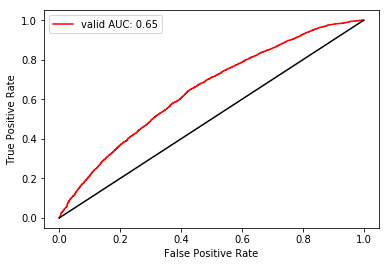

In [18]:

from sklearn.linear_model import LogisticRegression

Cs = [0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.5,1.0]
train_aucs = np.zeros(len(Cs))
valid_aucs = np.zeros(len(Cs))

for ii in range(len(Cs)):
    C = Cs[ii]
    print('\n C:', C)
    
    # logistic regression
    
    clf=LogisticRegression(C = C, penalty = 'l2', solver='lbfgs', random_state = 42,max_iter=500,n_jobs=n_jobs)
    clf.fit(df_train, y_train_binary)

    model = clf
    y_train_preds = model.predict_proba(df_train)[:,1]
    y_valid_preds = model.predict_proba(df_valid)[:,1]

    auc_train = roc_auc_score(y_train_binary, y_train_preds)
    auc_valid = roc_auc_score(y_valid_binary, y_valid_preds)
    
    print_metrics(y_train_binary.astype(np.int8), y_train_preds, name_first='valid',thresh = 0.5)
    
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid
    

In [28]:
clf = LogisticRegression(C=50. / len(df_train),
                         multi_class='multinomial',
                         penalty='l1', solver='saga',n_jobs=-1,max_iter=20)
clf.fit(df_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.0048828125, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=20, multi_class='multinomial', n_jobs=-1,
                   penalty='l1', random_state=None, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)

In [29]:
score = clf.score(df_valid, y_valid)
score

0.26090342679127726

In [37]:
clf1 = LogisticRegression(C=50. / len(df_train),
                         multi_class='multinomial',
                         penalty='l2', solver='saga',n_jobs=-1,max_iter=150)
clf1.fit(df_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.0048828125, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='multinomial', n_jobs=-1,
                   penalty='l2', random_state=None, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)

In [38]:
score = clf1.score(df_valid, y_valid)
score

0.29049844236760125

In [39]:
score = clf1.score(df_test, y_test)
score

0.26361483820047354

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


valid AUC:0.615
valid accuracy:0.601
valid recall:0.908
valid precision:0.595
valid F1:0.719
valid specificity:0.208
valid prevalence:0.562


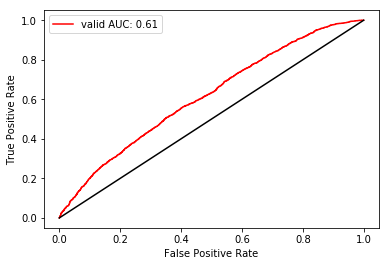

In [35]:
model=LogisticRegression(C=50. / len(df_train) , penalty = 'l2', solver='saga', random_state = 42,max_iter=150,n_jobs=-1)
model.fit(df_train, y_train_binary)
y_train_preds = model.predict_proba(df_train)[:,1]
y_valid_preds = model.predict_proba(df_valid)[:,1]

print_metrics(y_train_binary, y_train_preds, name_first='valid',thresh = 0.5)


# Random Forest fine-tuning and evaluation


 max_depth: 3
valid AUC:0.680
valid accuracy:0.522
valid recall:0.999
valid precision:0.521
valid F1:0.685
valid specificity:0.005
valid prevalence:0.520


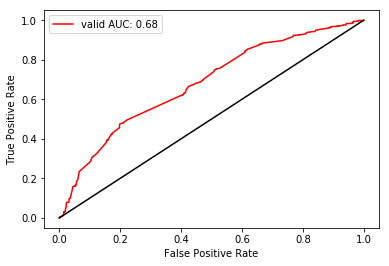


 max_depth: 5
valid AUC:0.672
valid accuracy:0.540
valid recall:0.984
valid precision:0.532
valid F1:0.690
valid specificity:0.060
valid prevalence:0.520


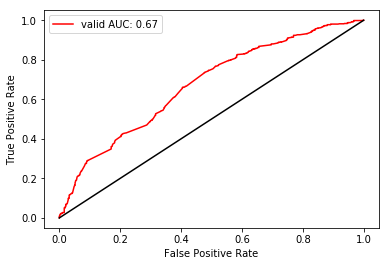


 max_depth: 7
valid AUC:0.680
valid accuracy:0.557
valid recall:0.966
valid precision:0.542
valid F1:0.694
valid specificity:0.114
valid prevalence:0.520


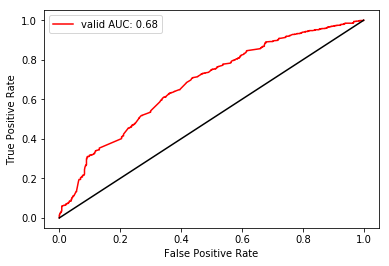


 max_depth: 9
valid AUC:0.700
valid accuracy:0.567
valid recall:0.969
valid precision:0.547
valid F1:0.699
valid specificity:0.131
valid prevalence:0.520


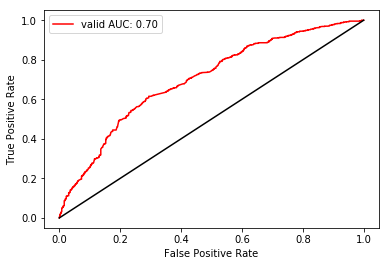


 max_depth: 11
valid AUC:0.660
valid accuracy:0.582
valid recall:0.957
valid precision:0.557
valid F1:0.704
valid specificity:0.175
valid prevalence:0.520


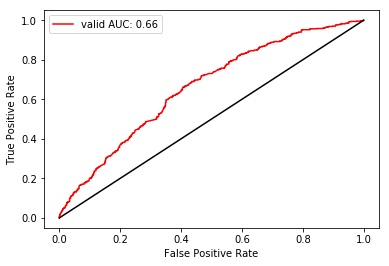


 max_depth: 13
valid AUC:0.667
valid accuracy:0.578
valid recall:0.931
valid precision:0.556
valid F1:0.697
valid specificity:0.195
valid prevalence:0.520


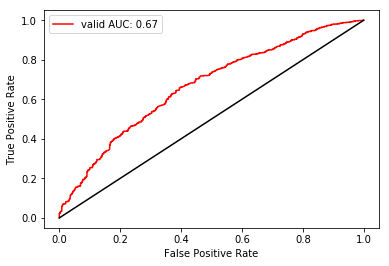


 max_depth: 15
valid AUC:0.688
valid accuracy:0.588
valid recall:0.912
valid precision:0.564
valid F1:0.697
valid specificity:0.237
valid prevalence:0.520


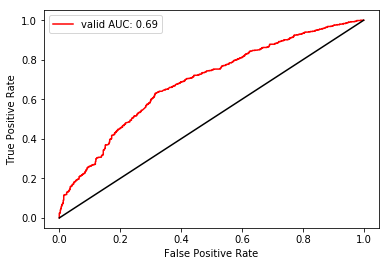


 max_depth: 17
valid AUC:0.670
valid accuracy:0.592
valid recall:0.888
valid precision:0.569
valid F1:0.694
valid specificity:0.271
valid prevalence:0.520


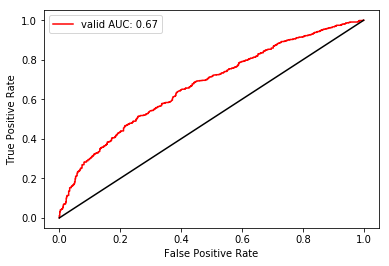


 max_depth: 19
valid AUC:0.664
valid accuracy:0.583
valid recall:0.912
valid precision:0.561
valid F1:0.695
valid specificity:0.227
valid prevalence:0.520


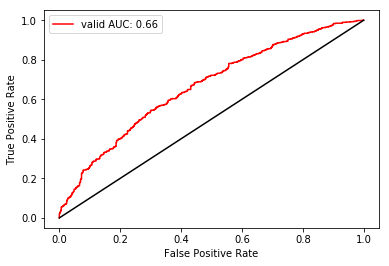


 max_depth: 21
valid AUC:0.673
valid accuracy:0.586
valid recall:0.894
valid precision:0.565
valid F1:0.692
valid specificity:0.253
valid prevalence:0.520


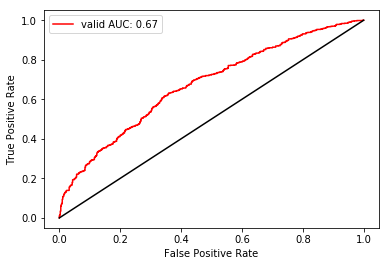


 max_depth: 23
valid AUC:0.689
valid accuracy:0.612
valid recall:0.859
valid precision:0.587
valid F1:0.697
valid specificity:0.344
valid prevalence:0.520


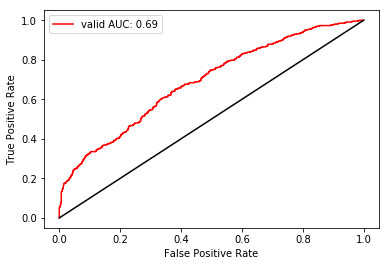

In [58]:
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.ensemble.forest import RandomForestClassifier

max_depths = list(range(3, 25, 2))
train_aucs = np.zeros(len(max_depths))
valid_aucs = np.zeros(len(max_depths))

train_acc = np.zeros(len(max_depths))
valid_acc = np.zeros(len(max_depths))

train_precision = np.zeros(len(max_depths))
valid_precision = np.zeros(len(max_depths))

train_recall = np.zeros(len(max_depths))
valid_recall = np.zeros(len(max_depths))

train_f1 = np.zeros(len(max_depths))
valid_f1 = np.zeros(len(max_depths))

train_spec = np.zeros(len(max_depths))
valid_spec = np.zeros(len(max_depths))


for ii in range(len(max_depths)):
    max_depth = max_depths[ii]
    print('\n max_depth:', max_depth)
    
    # Random Forest
    
    clf = RandomForestClassifier(max_depth = max_depth,min_samples_leaf = 1,min_samples_split = 4,n_estimators =10 , criterion = 'entropy', random_state = 42,n_jobs=20)
    clf.fit(df_train, y_train_binary)
    model=clf
    y_train_preds = model.predict_proba(df_train)[:,1]
    y_valid_preds = model.predict_proba(df_valid)[:,1]

    auc_train = roc_auc_score(y_train_binary, y_train_preds)
    auc_valid = roc_auc_score(y_valid_binary, y_valid_preds)
     
    print_metrics(y_valid_binary, y_valid_preds, name_first='valid',thresh = 0.5)
    
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid
    
    train_acc[ii] = calc_accuracy(y_train_binary, y_train_preds)
    valid_acc[ii] = calc_accuracy(y_valid_binary, y_valid_preds)
    
    train_precision[ii] = calc_precision(y_train_binary, y_train_preds)
    valid_precision[ii] = calc_precision(y_valid_binary, y_valid_preds)
    
    train_recall[ii] = calc_recall(y_train_binary, y_train_preds)
    valid_recall[ii] = calc_recall(y_valid_binary, y_valid_preds)
    
    train_f1[ii] = calc_f1(y_train_binary, y_train_preds)
    valid_f1[ii] = calc_f1(y_valid_binary, y_valid_preds)
    
    train_spec[ii] = calc_specificity(y_train_binary, y_train_preds)
    valid_spec[ii] = calc_specificity(y_valid_binary, y_valid_preds)
    

In [0]:
rf_results=pd.DataFrame({'max_depth':max_depths,'valid-auc':valid_aucs[:len(max_depths)],'valid-acc':valid_acc[:len(max_depths)],'valid-precision':valid_precision[:len(max_depths)],'valid-recall':valid_recall[:len(max_depths)],'valid_f1':valid_f1[:len(max_depths)]})

In [60]:
rf_results

,max_depth,valid-auc,valid-acc,valid-precision,valid-recall,valid_f1
0,3,0.680015,0.521807,0.521094,0.998503,0.684805
1,5,0.672123,0.540498,0.531553,0.983533,0.690126
2,7,0.680369,0.556854,0.541562,0.965569,0.693921
3,9,0.699621,0.566978,0.547377,0.968563,0.699459
4,11,0.659843,0.581776,0.557105,0.956587,0.704132
5,13,0.666993,0.577882,0.556351,0.931138,0.696529
6,15,0.688008,0.588006,0.564411,0.911677,0.697195
7,17,0.670063,0.591900,0.569098,0.887725,0.693567
8,19,0.663656,0.583333,0.561290,0.911677,0.694809
9,21,0.673379,0.586449,0.564806,0.893713,0.692174


In [0]:
best_depth = 23#max_depths[np.argmax(valid_acc)]


 min_split: 3
valid AUC:0.707
valid accuracy:0.614
valid recall:0.901
valid precision:0.583
valid F1:0.708
valid specificity:0.302
valid prevalence:0.520


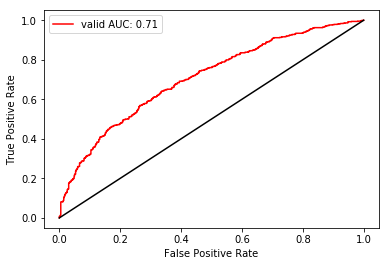


 min_split: 5
valid AUC:0.730
valid accuracy:0.608
valid recall:0.900
valid precision:0.580
valid F1:0.705
valid specificity:0.292
valid prevalence:0.520


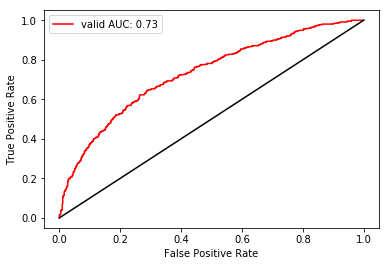


 min_split: 7
valid AUC:0.679
valid accuracy:0.589
valid recall:0.912
valid precision:0.565
valid F1:0.698
valid specificity:0.239
valid prevalence:0.520


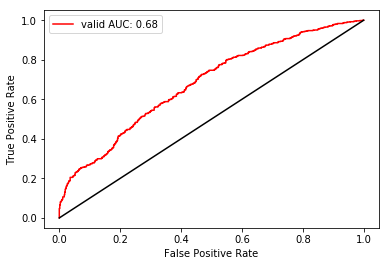


 min_split: 9
valid AUC:0.705
valid accuracy:0.619
valid recall:0.897
valid precision:0.588
valid F1:0.710
valid specificity:0.318
valid prevalence:0.520


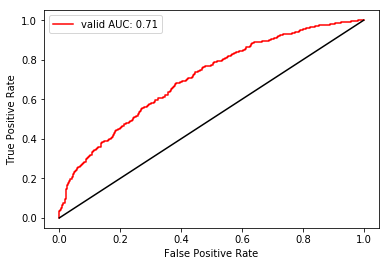


 min_split: 11
valid AUC:0.693
valid accuracy:0.600
valid recall:0.886
valid precision:0.575
valid F1:0.698
valid specificity:0.291
valid prevalence:0.520


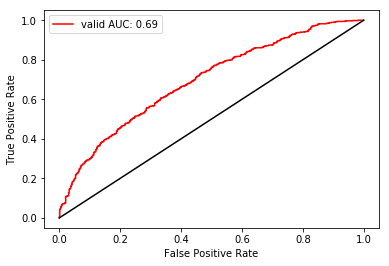


 min_split: 13
valid AUC:0.723
valid accuracy:0.632
valid recall:0.906
valid precision:0.596
valid F1:0.719
valid specificity:0.334
valid prevalence:0.520


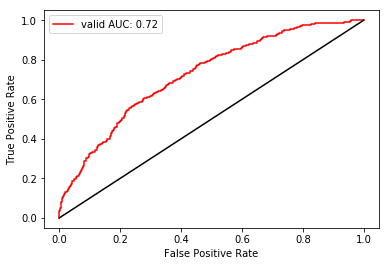


 min_split: 15
valid AUC:0.697
valid accuracy:0.602
valid recall:0.913
valid precision:0.574
valid F1:0.705
valid specificity:0.265
valid prevalence:0.520


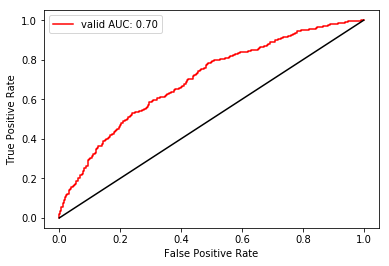


 min_split: 17
valid AUC:0.699
valid accuracy:0.588
valid recall:0.931
valid precision:0.563
valid F1:0.702
valid specificity:0.216
valid prevalence:0.520


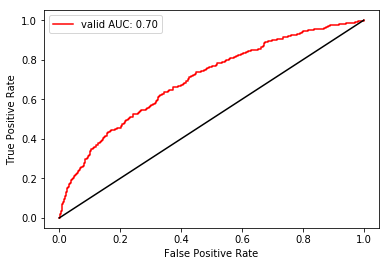


 min_split: 19
valid AUC:0.712
valid accuracy:0.597
valid recall:0.910
valid precision:0.571
valid F1:0.702
valid specificity:0.258
valid prevalence:0.520


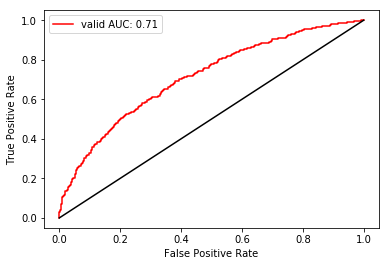


 min_split: 21
valid AUC:0.705
valid accuracy:0.595
valid recall:0.930
valid precision:0.568
valid F1:0.705
valid specificity:0.232
valid prevalence:0.520


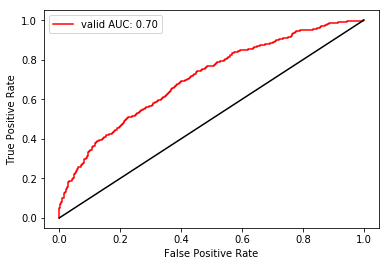


 min_split: 23
valid AUC:0.705
valid accuracy:0.623
valid recall:0.906
valid precision:0.590
valid F1:0.714
valid specificity:0.317
valid prevalence:0.520


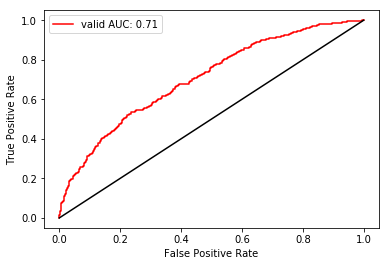

In [70]:
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.ensemble.forest import RandomForestClassifier

min_split = list(range(3, 25, 2))
train_aucs = np.zeros(len(max_depths))
valid_aucs = np.zeros(len(max_depths))

train_acc = np.zeros(len(max_depths))
valid_acc = np.zeros(len(max_depths))

train_precision = np.zeros(len(max_depths))
valid_precision = np.zeros(len(max_depths))

train_recall = np.zeros(len(max_depths))
valid_recall = np.zeros(len(max_depths))

train_f1 = np.zeros(len(max_depths))
valid_f1 = np.zeros(len(max_depths))

train_spec = np.zeros(len(max_depths))
valid_spec = np.zeros(len(max_depths))


for ii in range(len(max_depths)):
    max_depth = min_split[ii]
    print('\n min_split:', max_depth)
    
    # Random Forest
    
    clf = RandomForestClassifier(max_depth = best_depth,min_samples_leaf = max_depth,min_samples_split = max_depth,n_estimators =10 , criterion = 'entropy', random_state = 42,n_jobs=20)
    clf.fit(df_train, y_train_binary)
    model=clf
    y_train_preds = model.predict_proba(df_train)[:,1]
    y_valid_preds = model.predict_proba(df_valid)[:,1]

    auc_train = roc_auc_score(y_train_binary, y_train_preds)
    auc_valid = roc_auc_score(y_valid_binary, y_valid_preds)
     
    print_metrics(y_valid_binary, y_valid_preds, name_first='valid',thresh = 0.5)
    
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid
    
    train_acc[ii] = calc_accuracy(y_train_binary, y_train_preds)
    valid_acc[ii] = calc_accuracy(y_valid_binary, y_valid_preds)
    
    train_precision[ii] = calc_precision(y_train_binary, y_train_preds)
    valid_precision[ii] = calc_precision(y_valid_binary, y_valid_preds)
    
    train_recall[ii] = calc_recall(y_train_binary, y_train_preds)
    valid_recall[ii] = calc_recall(y_valid_binary, y_valid_preds)
    
    train_f1[ii] = calc_f1(y_train_binary, y_train_preds)
    valid_f1[ii] = calc_f1(y_valid_binary, y_valid_preds)
    
    train_spec[ii] = calc_specificity(y_train_binary, y_train_preds)
    valid_spec[ii] = calc_specificity(y_valid_binary, y_valid_preds)
    

In [0]:
rf_results=pd.DataFrame({'min_sample_leaf':min_split,'min_sample_split':min_split,'valid-auc':valid_aucs[:len(max_depths)],'valid-acc':valid_acc[:len(max_depths)],'valid-precision':valid_precision[:len(max_depths)],'valid-recall':valid_recall[:len(max_depths)],'valid_f1':valid_f1[:len(max_depths)]})

In [73]:
rf_results

,min_sample_leaf,min_sample_split,valid-auc,valid-acc,valid-precision,valid-recall,valid_f1
0,3,3,0.706600,0.613707,0.583333,0.901198,0.708235
1,5,5,0.729736,0.608255,0.579556,0.899701,0.704985
2,7,7,0.678725,0.588785,0.564935,0.911677,0.697595
3,9,9,0.705243,0.619159,0.587831,0.896707,0.710136
4,11,11,0.693410,0.600467,0.575316,0.886228,0.697702
5,13,13,0.723377,0.631620,0.596059,0.905689,0.718954
6,15,15,0.697401,0.602025,0.573848,0.913174,0.704795
7,17,17,0.698973,0.588006,0.562896,0.931138,0.701636
8,19,19,0.712325,0.597352,0.570892,0.910180,0.701673
9,21,21,0.704837,0.595016,0.567642,0.929641,0.704881


In [0]:
best_split = 13 #max_depths[np.argmax(valid_acc)]


 trees: 10
valid AUC:0.798
valid accuracy:0.705
valid recall:0.825
valid precision:0.678
valid F1:0.744
valid specificity:0.575
valid prevalence:0.520


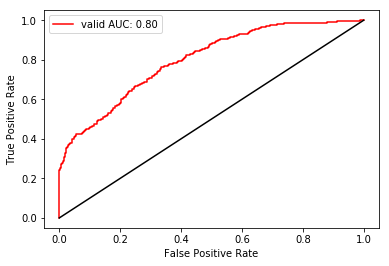


 trees: 30
valid AUC:0.818
valid accuracy:0.708
valid recall:0.879
valid precision:0.666
valid F1:0.758
valid specificity:0.523
valid prevalence:0.520


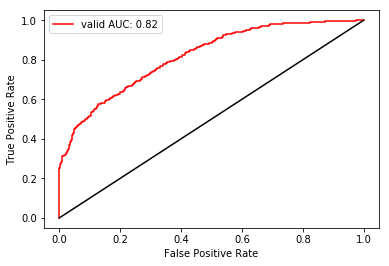


 trees: 50
valid AUC:0.824
valid accuracy:0.710
valid recall:0.873
valid precision:0.670
valid F1:0.758
valid specificity:0.534
valid prevalence:0.520


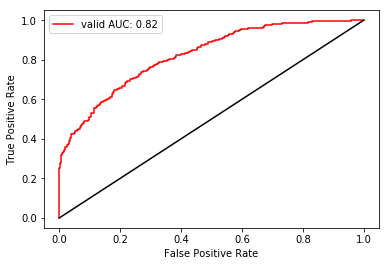


 trees: 70
valid AUC:0.823
valid accuracy:0.713
valid recall:0.868
valid precision:0.674
valid F1:0.759
valid specificity:0.544
valid prevalence:0.520


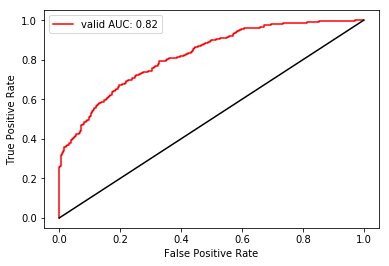


 trees: 90
valid AUC:0.825
valid accuracy:0.713
valid recall:0.876
valid precision:0.672
valid F1:0.760
valid specificity:0.536
valid prevalence:0.520


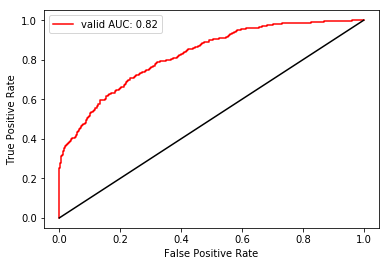


 trees: 110
valid AUC:0.828
valid accuracy:0.712
valid recall:0.876
valid precision:0.671
valid F1:0.760
valid specificity:0.534
valid prevalence:0.520


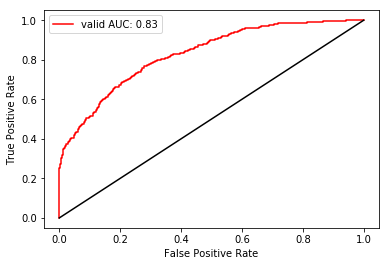


 trees: 130
valid AUC:0.828
valid accuracy:0.710
valid recall:0.877
valid precision:0.669
valid F1:0.759
valid specificity:0.529
valid prevalence:0.520


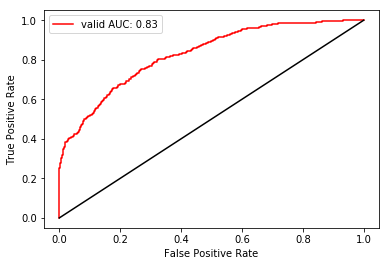


 trees: 150
valid AUC:0.828
valid accuracy:0.706
valid recall:0.871
valid precision:0.666
valid F1:0.755
valid specificity:0.526
valid prevalence:0.520


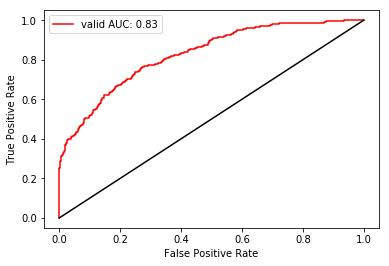


 trees: 170
valid AUC:0.828
valid accuracy:0.705
valid recall:0.870
valid precision:0.666
valid F1:0.754
valid specificity:0.526
valid prevalence:0.520


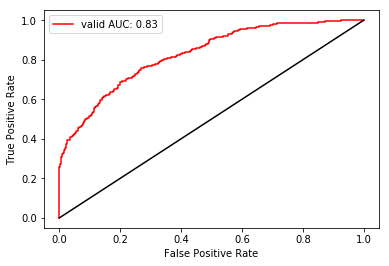


 trees: 190
valid AUC:0.828
valid accuracy:0.709
valid recall:0.870
valid precision:0.669
valid F1:0.757
valid specificity:0.534
valid prevalence:0.520


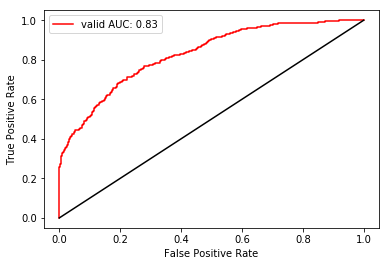

IndexError: ignored

In [75]:
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.ensemble.forest import RandomForestClassifier

trees = list(range(10, 100, 20))
train_aucs = np.zeros(len(max_depths))
valid_aucs = np.zeros(len(max_depths))

train_acc = np.zeros(len(max_depths))
valid_acc = np.zeros(len(max_depths))

train_precision = np.zeros(len(max_depths))
valid_precision = np.zeros(len(max_depths))

train_recall = np.zeros(len(max_depths))
valid_recall = np.zeros(len(max_depths))

train_f1 = np.zeros(len(max_depths))
valid_f1 = np.zeros(len(max_depths))

train_spec = np.zeros(len(max_depths))
valid_spec = np.zeros(len(max_depths))


for ii in range(len(max_depths)):
    max_depth = trees[ii]
    print('\n trees:', max_depth)
    
    # Random Forest
    
    clf = RandomForestClassifier(max_features = 0.6, max_depth = best_depth,min_samples_leaf = best_split,min_samples_split = best_split,n_estimators =max_depth , criterion = 'entropy', random_state = 42,n_jobs=20)
    clf.fit(df_train, y_train_binary)
    model=clf
    y_train_preds = model.predict_proba(df_train)[:,1]
    y_valid_preds = model.predict_proba(df_valid)[:,1]

    auc_train = roc_auc_score(y_train_binary, y_train_preds)
    auc_valid = roc_auc_score(y_valid_binary, y_valid_preds)
     
    print_metrics(y_valid_binary, y_valid_preds, name_first='valid',thresh = 0.5)
    
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid
    
    train_acc[ii] = calc_accuracy(y_train_binary, y_train_preds)
    valid_acc[ii] = calc_accuracy(y_valid_binary, y_valid_preds)
    
    train_precision[ii] = calc_precision(y_train_binary, y_train_preds)
    valid_precision[ii] = calc_precision(y_valid_binary, y_valid_preds)
    
    train_recall[ii] = calc_recall(y_train_binary, y_train_preds)
    valid_recall[ii] = calc_recall(y_valid_binary, y_valid_preds)
    
    train_f1[ii] = calc_f1(y_train_binary, y_train_preds)
    valid_f1[ii] = calc_f1(y_valid_binary, y_valid_preds)
    
    train_spec[ii] = calc_specificity(y_train_binary, y_train_preds)
    valid_spec[ii] = calc_specificity(y_valid_binary, y_valid_preds)
    

In [0]:
best_trees =  70 #max_depths[np.argmax(valid_acc)]

test AUC:0.823
test accuracy:0.713
test recall:0.868
test precision:0.674
test F1:0.759
test specificity:0.544
test prevalence:0.520


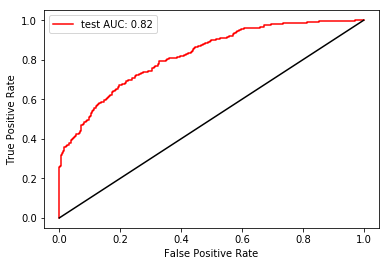

test AUC:0.803
test accuracy:0.714
test recall:0.889
test precision:0.692
test F1:0.778
test specificity:0.488
test prevalence:0.564


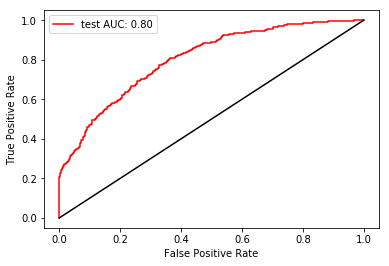

In [50]:
model = RandomForestClassifier(max_features=0.6,max_depth = best_depth,min_samples_leaf = best_split,min_samples_split = best_split,n_estimators = best_trees , criterion = 'entropy', random_state = 42,n_jobs=20)
model.fit(df_train, y_train_binary)
y_train_preds = model.predict_proba(df_train)[:,1]
y_test_preds = model.predict_proba(df_test)[:,1]
y_valid_preds = model.predict_proba(df_valid)[:,1]

print_metrics(y_valid_binary, y_valid_preds, name_first='test',thresh = 0.5)
print_metrics(y_test_binary, y_test_preds, name_first='test',thresh = 0.5)

In [0]:
# dic_labels = {'pants-fire':0,
#              'false':1,
#              'barely-true':2,
#              'half-true':3,
#              'mostly-true':4,
#              'true':5}
# y_train = np.array([dic_labels[x] for x in y_train])
# y_valid = np.array([dic_labels[x] for x in y_valid])
# y_test  = np.array([dic_labels[x] for x in y_test])

In [0]:
clf = RandomForestClassifier(max_features=0.6,max_depth = best_depth,min_samples_leaf = best_split,min_samples_split = best_split,n_estimators = 1 , criterion = 'entropy', random_state = 42,n_jobs=20)
clf.fit(df_train, y_train)



In [39]:
score = clf.score(df_valid, y_valid)
score

0.37694704049844235

In [49]:
score = clf.score(df_test, y_test)
score

0.35201262825572216

In [0]:
y_test_pred = clf.predict(df_test)

In [46]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_test_pred, target_names=pd.DataFrame({'target':y_test})['target'].unique()))

              precision    recall  f1-score   support

        true       0.32      0.33      0.32       212
       false       0.34      0.38      0.36       249
   half-true       0.37      0.39      0.38       265
  pants-fire       0.39      0.36      0.37       241
 barely-true       0.36      0.47      0.40        92
 mostly-true       0.32      0.24      0.27       208

    accuracy                           0.35      1267
   macro avg       0.35      0.36      0.35      1267
weighted avg       0.35      0.35      0.35      1267



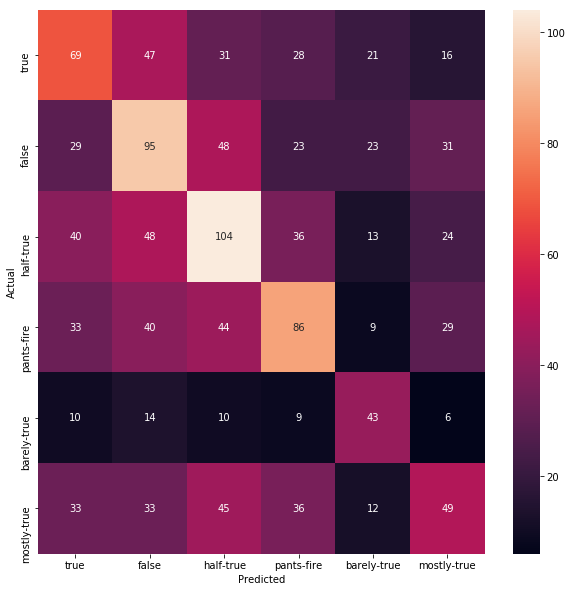

In [48]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=pd.DataFrame({'target':y_test})['target'].unique(), yticklabels=pd.DataFrame({'target':y_test})['target'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()